In [9]:
import numpy as np
import tensorflow.keras
import torch
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv1D, AveragePooling1D, Conv2D, MaxPooling2D,ReLU
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model #save and load models
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
import IPython.display as ipd
from kymatio import Scattering1D
import hitdifferentparts
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import pescador
import random
import os
import librosa
import pickle

In [10]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [11]:
pkl_dir = "/scratch/hh2263/drum_data/pkl_data/"
os.listdir(pkl_dir)

['scattering_J-06_Q-01_order2.pkl',
 'scattering_J-10_Q-01_order1.pkl',
 'scattering_J-12_Q-01_order1.pkl',
 'scattering_J-14_Q-01_order1.pkl',
 'scattering_J-06_Q-01_order1.pkl',
 'scattering_J-08_Q-01_order1.pkl',
 'scattering_J-10_Q-01_order2.pkl',
 'scattering_J-08_Q-01_order2.pkl',
 'scattering_J-12_Q-01_order2.pkl',
 'scattering_J-14_Q-01_order2.pkl']

In [12]:
!nvidia-smi

Thu Mar 12 21:35:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:86:00.0 Off |                    0 |
| N/A   28C    P0    39W / 300W |     11MiB / 32510MiB |      0%   E. Process |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [13]:
# open J-8,Q=1,O=2 pkl file
J = 8
Q = 1
order = 2
pkl_path = '/scratch/hh2263/drum_data/pkl_data/scattering_J-08_Q-01_order2.pkl'
pkl_file = open(pkl_path, 'rb')
Sy_train,y_train = pickle.load(pkl_file) 

pkl_path_val = '/scratch/hh2263/drum_data/val/J_8_Q_1_order_2.pkl'
pkl_val = open(pkl_path_val,'rb')
Sy_val,y_val = pickle.load(pkl_val)
Sy_val = Sy_val.reshape((Sy_val.shape[2],Sy_val.shape[0],Sy_val.shape[1]))

In [14]:
input_x = Sy_train.shape[1]
input_y = Sy_train.shape[2]
print(Sy_train.shape,Sy_val.shape,y_train.shape,y_val.shape,input_x,input_y)

(82224, 128, 43) (7776, 128, 43) (82224, 5) (7776, 5) 128 43


In [15]:
!nvidia-smi

Thu Mar 12 21:35:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:86:00.0 Off |                    0 |
| N/A   28C    P0    40W / 300W |     11MiB / 32510MiB |      0%   E. Process |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [16]:
df_train = pd.read_csv("./train_param.csv")
df_test = pd.read_csv("./test_param.csv")
df_val = pd.read_csv("./val_param.csv")
df_full = pd.read_csv("./diffshapes_param.csv")

# normalization of the physical parameters
params = df_train.values[:,1:-1]
scaler = MinMaxScaler()
scaler.fit(params)

#normalize training and validation set
y_train_normalized = scaler.transform(y_train)
y_val_normalized = scaler.transform(y_val)

In [17]:
#make the model
def create_model(J,Q,order,input_x,input_y,k_size,layer_size,nchan_out):
    #fname = random.choice(os.listdir(path_to_train))
    #rand_audio = os.path.join(path_to_train,fname)
    #y,sr = librosa.load(rand_audio)
    #N = len(y)
    #scattering = Scattering1D(J = J,shape=(N,), Q = Q, max_order=order)
    
    #Sy = getsc_new(torch.Tensor(y),J,Q,order,scattering).T
    #nrow, ncol = Sy.shape 
    nrow = input_x
    ncol = input_y
    #naudio = batch_size         # number of images in batch
    nchan_in = 1       # number of input channels.  1 since it is BW
    #input_shape = (nrow,ncol,nchan_in)  # input shape of 1 image
    input_shape = (input_x,input_y)#Sy.shape
    #batch_shape = (naudio,nrow,ncol,nchan_in)  # shape of image batch
    #x = Sy.reshape(batch_shape)
    kernel_size = (k_size,)
    #nchan_out = 16

    K.clear_session()
    model=Sequential()
    #1 conv layer +  1 batch normalization + nonlinear activation + pooling
    model.add(Conv1D(input_shape=input_shape, filters=nchan_out,
                     kernel_size=kernel_size, padding="same",name='conv1'))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(AveragePooling1D(pool_size=(4,)))
    
   #second time
    model.add(Conv1D(filters=nchan_out,
                     kernel_size=kernel_size, padding="same",name='conv2' ))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(AveragePooling1D(pool_size=(4,)))
    
    #third time
    if layer_size>=3:
        model.add(Conv1D(filters=nchan_out,
                         kernel_size=kernel_size, padding="same",name='conv3' ))
        model.add(BatchNormalization())
        model.add(Activation("relu"))
        model.add(AveragePooling1D(pool_size=(4,)))
        if layer_size==4:
        #fourth time
            model.add(Conv1D(filters=nchan_out,
                             kernel_size=kernel_size, padding="same",name='conv4' ))
            model.add(BatchNormalization())
            model.add(Activation("relu"))
            model.add(AveragePooling1D(pool_size=(2,)))

    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    #what activation should be chosen for last layer, for regression problem? should be a linear function
    model.add(Dense(5, activation='linear')) #output layer that corresponds to the 5 physical parameters.


    # Compile the model
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    
    #print(model.summary())
    return model

In [9]:
model = create_model(J,Q,order,input_x,input_y,k_size=8,layer_size=4,nchan_out=16)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv1D)               (None, 128, 16)           5520      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 16)           64        
_________________________________________________________________
activation (Activation)      (None, 128, 16)           0         
_________________________________________________________________
average_pooling1d (AveragePo (None, 32, 16)            0         
_________________________________________________________________
conv2 (Conv1D)               (None, 32, 16)            2064      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 16)            64        
_________________________________________

In [12]:
!nvidia-smi

Thu Mar 12 14:51:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.39       Driver Version: 418.39       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P40           On   | 00000000:04:00.0 Off |                    0 |
| N/A   15C    P8    13W / 250W |     10MiB / 22919MiB |      0%   E. Process |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P40           On   | 00000000:05:00.0 Off |                    0 |
| N/A   13C    P8     9W / 250W |     10MiB / 22919MiB |      0%   E. Process |
+-------------------------------+----------------------+----------------------+
        

## training everything at once and validate - apparently overfitted

In [12]:
model.fit(Sy_train,
          y_train_normalized,
          epochs=1,
          verbose=1,
          batch_size=32,
          validation_data = (Sy_val,y_val_normalized),
         use_multiprocessing=True)

Train on 82224 samples, validate on 7776 samples
82224/82224 [==============================] - 21s 250us/sample - loss: 0.0448 - mean_squared_error: 0.0448 - val_loss: 11544.8017 - val_mean_squared_error: 11544.7998


## reduce model complexity to 3 layers - worse

In [121]:
model2 = create_model(J,Q,order,input_x,input_y,k_size=8,layer_size=3,nchan_out=16)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv1D)               (None, 128, 16)           5520      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 16)           64        
_________________________________________________________________
activation (Activation)      (None, 128, 16)           0         
_________________________________________________________________
average_pooling1d (AveragePo (None, 32, 16)            0         
_________________________________________________________________
conv2 (Conv1D)               (None, 32, 16)            2064      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 16)            64        
_________________________________________________________________
activation_1 (Activation)    (None, 32, 16)            0

In [122]:
epochs = 12

hist = model2.fit(Sy_train,
          y_train_normalized,
          epochs=epochs,
          verbose=1,
          batch_size=8192,
          validation_data = (Sy_val,y_val_normalized),
         use_multiprocessing=True)

Train on 82224 samples, validate on 7776 samples
Epoch 1/12
82224/82224 [==============================] - 4s 49us/sample - loss: 0.7013 - mean_squared_error: 0.7013 - val_loss: 0.1251 - val_mean_squared_error: 0.1251
Epoch 2/12
82224/82224 [==============================] - 3s 33us/sample - loss: 0.2267 - mean_squared_error: 0.2267 - val_loss: 0.0961 - val_mean_squared_error: 0.0961
Epoch 3/12
82224/82224 [==============================] - 3s 34us/sample - loss: 0.1470 - mean_squared_error: 0.1470 - val_loss: 0.0755 - val_mean_squared_error: 0.0755
Epoch 4/12
82224/82224 [==============================] - 3s 34us/sample - loss: 0.1043 - mean_squared_error: 0.1043 - val_loss: 0.0641 - val_mean_squared_error: 0.0641
Epoch 5/12
82224/82224 [==============================] - 3s 34us/sample - loss: 0.0790 - mean_squared_error: 0.0790 - val_loss: 0.0606 - val_mean_squared_error: 0.0606
Epoch 6/12
82224/82224 [==============================] - 3s 33us/sample - loss: 0.0630 - mean_squared_err

In [18]:
import matplotlib.pyplot as plt

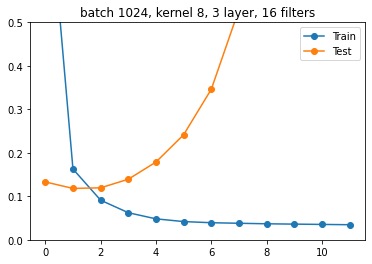

In [113]:
plt.plot(hist.history['loss'],'o-')
plt.plot(hist.history['val_loss'],'o-')
plt.title("batch 4096, kernel 8, 3 layer, 16 filters")
plt.ylim([0,0.5])
plt.legend(['Train', 'Test'])
plt.show()

In [119]:
nrow = input_x
ncol = input_y
nchan_in = 1       # number of input channels.  1 since it is BW
input_shape = (input_x,input_y)#Sy.shape
kernel_size = (3,)
nchan_out = 16

K.clear_session()
model=Sequential()
#1 conv layer +  1 batch normalization + nonlinear activation + pooling
model.add(Conv1D(input_shape=input_shape, filters=nchan_out,
                 kernel_size=kernel_size, padding="same",name='conv1'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(AveragePooling1D(pool_size=(4,)))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
#what activation should be chosen for last layer, for regression problem? should be a linear function
model.add(Dense(5, activation='linear')) #output layer that corresponds to the 5 physical parameters.


# Compile the model
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv1D)               (None, 128, 16)           2080      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 16)           64        
_________________________________________________________________
activation (Activation)      (None, 128, 16)           0         
_________________________________________________________________
average_pooling1d (AveragePo (None, 32, 16)            0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 16)            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 16)            64        
_________________________________________________________________
flatten (Flatten)            (None, 512)               0

In [120]:
hist4 = model.fit(Sy_train,
          y_train_normalized,
          epochs=12,
          verbose=1,
          batch_size=8192,
          shuffle=True,
          validation_data = (Sy_val,y_val_normalized),
         use_multiprocessing=True)

Train on 82224 samples, validate on 7776 samples
Epoch 1/12
82224/82224 [==============================] - 3s 41us/sample - loss: 0.9169 - mean_squared_error: 0.9169 - val_loss: 0.1815 - val_mean_squared_error: 0.1815
Epoch 2/12
82224/82224 [==============================] - 3s 32us/sample - loss: 0.3707 - mean_squared_error: 0.3707 - val_loss: 0.2997 - val_mean_squared_error: 0.2997
Epoch 3/12
82224/82224 [==============================] - 3s 32us/sample - loss: 0.2392 - mean_squared_error: 0.2392 - val_loss: 0.4699 - val_mean_squared_error: 0.4699
Epoch 4/12
82224/82224 [==============================] - 3s 31us/sample - loss: 0.1861 - mean_squared_error: 0.1861 - val_loss: 0.6133 - val_mean_squared_error: 0.6133
Epoch 5/12
82224/82224 [==============================] - 3s 32us/sample - loss: 0.1534 - mean_squared_error: 0.1534 - val_loss: 0.7342 - val_mean_squared_error: 0.7342
Epoch 6/12
82224/82224 [==============================] - 3s 32us/sample - loss: 0.1318 - mean_squared_err

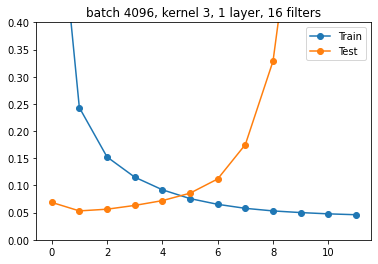

In [109]:
plt.plot(hist4.history['loss'],'o-')
plt.plot(hist4.history['val_loss'],'o-')
plt.ylim([0,0.4])
plt.title("batch 4096, kernel 3, 1 layer, 16 filters")
plt.legend(['Train', 'Test'])
plt.show()



## increase kernel size helped

In [115]:
model3 = create_model(J,Q,order,input_x,input_y,k_size=16,layer_size=4,nchan_out=16)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv1D)               (None, 128, 16)           11024     
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 16)           64        
_________________________________________________________________
activation (Activation)      (None, 128, 16)           0         
_________________________________________________________________
average_pooling1d (AveragePo (None, 32, 16)            0         
_________________________________________________________________
conv2 (Conv1D)               (None, 32, 16)            4112      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 16)            64        
_________________________________________________________________
activation_1 (Activation)    (None, 32, 16)            0

In [116]:
hist3 = model3.fit(Sy_train,
          y_train_normalized,
          epochs=12,
          verbose=1,
          batch_size=8192,
          validation_data = (Sy_val,y_val_normalized),
         use_multiprocessing=True)

Train on 82224 samples, validate on 7776 samples
Epoch 1/12
82224/82224 [==============================] - 5s 55us/sample - loss: 0.7766 - mean_squared_error: 0.7766 - val_loss: 0.1347 - val_mean_squared_error: 0.1347
Epoch 2/12
82224/82224 [==============================] - 3s 35us/sample - loss: 0.2300 - mean_squared_error: 0.2300 - val_loss: 0.1110 - val_mean_squared_error: 0.1110
Epoch 3/12
82224/82224 [==============================] - 3s 35us/sample - loss: 0.1525 - mean_squared_error: 0.1525 - val_loss: 0.0903 - val_mean_squared_error: 0.0903
Epoch 4/12
82224/82224 [==============================] - 3s 36us/sample - loss: 0.1120 - mean_squared_error: 0.1120 - val_loss: 0.0751 - val_mean_squared_error: 0.0751
Epoch 5/12
82224/82224 [==============================] - 3s 35us/sample - loss: 0.0863 - mean_squared_error: 0.0863 - val_loss: 0.0659 - val_mean_squared_error: 0.0659
Epoch 6/12
82224/82224 [==============================] - 3s 35us/sample - loss: 0.0688 - mean_squared_err

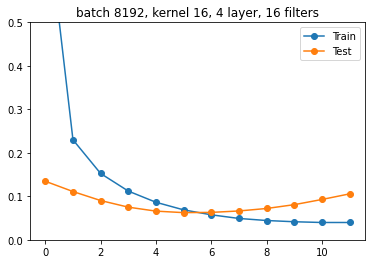

In [117]:
plt.plot(hist3.history['loss'],'o-')
plt.plot(hist3.history['val_loss'],'o-')
plt.ylim([0,0.5])
plt.title("batch 8192, kernel 16, 4 layer, 16 filters")
plt.legend(['Train', 'Test'])
plt.show()


## with 4 layers, try comb of kernel size + num_filters, batch 4096/8192, find min loss, early stop stage

In [ ]:
a

In [7]:
a=np.array([1,2,3])
np.where(a==3)[0][0]

2

In [21]:
k_size = [4,8,16]
nchan_out = [8,16,32]
batch_size=[4096,8192]
comb = [(4,8),(8,8),(16,8),(8,16),(16,16)]
records_4 = []
for k,nout in comb:
    for bs in batch_size:
        model = create_model(J,Q,order,input_x,input_y,k_size=k,layer_size=4,nchan_out=nout)
        hist = model.fit(Sy_train,
                  y_train_normalized,
                  epochs=8,
                  verbose=2,
                  batch_size=bs,
                  validation_data = (Sy_val,y_val_normalized),
                 use_multiprocessing=True)

        min_loss = min(hist.history['val_loss'])
        stop = np.where(np.array(hist.history['val_loss']==min_loss))
        records_4.append((k,nout,bs,min_loss,stop))


            
            
            
            
            

Train on 82224 samples, validate on 7776 samples
Epoch 1/8
82224/82224 - 36s - loss: 0.7189 - mean_squared_error: 0.7189 - val_loss: 0.1030 - val_mean_squared_error: 0.1030
Epoch 2/8
82224/82224 - 3s - loss: 0.1963 - mean_squared_error: 0.1963 - val_loss: 0.0630 - val_mean_squared_error: 0.0630
Epoch 3/8
82224/82224 - 3s - loss: 0.1089 - mean_squared_error: 0.1089 - val_loss: 0.0377 - val_mean_squared_error: 0.0377
Epoch 4/8
82224/82224 - 3s - loss: 0.0759 - mean_squared_error: 0.0759 - val_loss: 0.0267 - val_mean_squared_error: 0.0267
Epoch 5/8
82224/82224 - 3s - loss: 0.0605 - mean_squared_error: 0.0605 - val_loss: 0.0255 - val_mean_squared_error: 0.0255
Epoch 6/8
82224/82224 - 3s - loss: 0.0533 - mean_squared_error: 0.0533 - val_loss: 0.0280 - val_mean_squared_error: 0.0280
Epoch 7/8
82224/82224 - 3s - loss: 0.0497 - mean_squared_error: 0.0497 - val_loss: 0.0308 - val_mean_squared_error: 0.0308
Epoch 8/8
82224/82224 - 3s - loss: 0.0473 - mean_squared_error: 0.0473 - val_loss: 0.0328

Train on 82224 samples, validate on 7776 samples
Epoch 1/8
82224/82224 - 116s - loss: 0.4880 - mean_squared_error: 0.4880 - val_loss: 0.1047 - val_mean_squared_error: 0.1047
Epoch 2/8
82224/82224 - 3s - loss: 0.1285 - mean_squared_error: 0.1285 - val_loss: 0.0749 - val_mean_squared_error: 0.0749
Epoch 3/8
82224/82224 - 3s - loss: 0.0737 - mean_squared_error: 0.0737 - val_loss: 0.0598 - val_mean_squared_error: 0.0598
Epoch 4/8
82224/82224 - 3s - loss: 0.0511 - mean_squared_error: 0.0511 - val_loss: 0.0633 - val_mean_squared_error: 0.0633
Epoch 5/8
82224/82224 - 3s - loss: 0.0418 - mean_squared_error: 0.0418 - val_loss: 0.0790 - val_mean_squared_error: 0.0790
Epoch 6/8
82224/82224 - 3s - loss: 0.0385 - mean_squared_error: 0.0385 - val_loss: 0.1023 - val_mean_squared_error: 0.1023
Epoch 7/8
82224/82224 - 4s - loss: 0.0373 - mean_squared_error: 0.0373 - val_loss: 0.1311 - val_mean_squared_error: 0.1311
Epoch 8/8
82224/82224 - 4s - loss: 0.0367 - mean_squared_error: 0.0367 - val_loss: 0.166

In [22]:
records_4

[(4, 8, 4096, 0.025546350742502468, (array([4]),)),
 (4, 8, 8192, 0.05544932931661606, (array([7]),)),
 (8, 8, 4096, 0.03246455619671217, (array([5]),)),
 (8, 8, 8192, 0.0281909741461277, (array([7]),)),
 (16, 8, 4096, 0.047385030782517094, (array([4]),)),
 (16, 8, 8192, 0.041152287274599075, (array([7]),)),
 (8, 16, 4096, 0.03884700336206107, (array([4]),)),
 (8, 16, 8192, 0.025601018220186234, (array([7]),)),
 (16, 16, 4096, 0.0598188233810933, (array([2]),)),
 (16, 16, 8192, 0.05011123791337013, (array([7]),))]

In [19]:
#conclusion: the shallower the better, best to keep nchan_out around 8
records

[(4, 8, 4096, 0.03966056429800183, (array([4]),)),
 (4, 8, 8192, 0.03644775226712227, (array([4]),)),
 (4, 16, 4096, 0.14485471551555665, (array([0]),)),
 (4, 16, 8192, 0.0906657725572586, (array([2]),)),
 (4, 32, 4096, 0.08531263988817671, (array([3]),)),
 (4, 32, 8192, 0.17081204056739807, (array([0]),)),
 (8, 8, 4096, 0.04856658303811227, (array([2]),)),
 (8, 8, 8192, 0.11286333948373795, (array([3]),)),
 (8, 16, 4096, 0.051967467162221545, (array([2]),)),
 (8, 16, 8192, 0.12133724242448807, (array([4]),)),
 (8, 32, 4096, 0.13176565847279112, (array([1]),)),
 (8, 32, 8192, 0.12348516285419464, (array([2]),)),
 (16, 8, 4096, 0.032094263276200234, (array([2]),)),
 (16, 8, 8192, 0.048853788524866104, (array([7]),))]

In [17]:
model4 = create_model(J,Q,order,input_x,input_y,k_size=16,layer_size=3,nchan_out=16)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv1D)               (None, 128, 16)           11024     
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 16)           64        
_________________________________________________________________
activation (Activation)      (None, 128, 16)           0         
_________________________________________________________________
average_pooling1d (AveragePo (None, 32, 16)            0         
_________________________________________________________________
conv2 (Conv1D)               (None, 32, 16)            4112      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 16)            64        
_________________________________________________________________
activation_1 (Activation)    (None, 32, 16)            0

In [14]:
output_dir = "../output/train_pkl"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
model_filepath = os.path.join(output_dir, "cp.ckpt")
log_filepath = os.path.join(output_dir, 'train_log.csv')

callbacks = []
callbacks.append(EarlyStopping(monitor='val_loss',patience=0,verbose=1))
callbacks.append(ModelCheckpoint(model_filepath, save_best_only=True))
callbacks.append(CSVLogger(log_filepath))

In [19]:
for epoch in range(3):
    model4.fit(Sy_train,
              y_train_normalized,
              epochs=1,
              verbose=1,
              batch_size=1024,
              shuffle=True,
              callbacks = callbacks,
              validation_data = (Sy_val,y_val_normalized),
             use_multiprocessing=True)

Train on 82224 samples, validate on 7776 samples
82224/82224 [==============================] - 3s 38us/sample - loss: 0.2229 - mean_squared_error: 0.2229 - val_loss: 0.0458 - val_mean_squared_error: 0.0458
Train on 82224 samples, validate on 7776 samples
82224/82224 [==============================] - 2s 21us/sample - loss: 0.0382 - mean_squared_error: 0.0382 - val_loss: 0.2898 - val_mean_squared_error: 0.2898
Train on 82224 samples, validate on 7776 samples
82224/82224 [==============================] - 2s 21us/sample - loss: 0.0336 - mean_squared_error: 0.0336 - val_loss: 1.3946 - val_mean_squared_error: 1.3946


## try with data generator - kernel keeps restarting when i call fit

In [15]:
def feature_sampler(Sy_all,y_all,idx):
    """
    output a {input, ground truth} pair for the designated audio sample
    """
    i=idx
    Sy = Sy_all[i,:,:]
    y = y_all[i,:]
    while True:
        yield {'input': Sy,'y': y}

        
def data_generator(Sy_all,y_all, batch_size, idx, active_streamers,rate,mode,random_state):
    """
    use streamers to output a batch of {input groundtruth} pairs. 
    """

    seeds = []
    for i in idx:
        streamer = pescador.Streamer(feature_sampler,Sy_all,y_all,i)
        seeds.append(streamer)

    # Randomly shuffle the seeds
    random.shuffle(seeds)

    mux = pescador.StochasticMux(seeds, active_streamers, rate=rate, random_state=random_state,mode=mode)
   
    if batch_size == 1:
        return mux
    else:
        return pescador.maps.buffer_stream(mux, batch_size)




In [16]:
epochs=12
batch_size=32
random_state=12345678
active_streamers=32
mode='with_replacement'
rate=1
train_idx = np.arange(0,Sy_train.shape[0],1)
train_batches=data_generator(Sy_train,y_train_normalized,batch_size, train_idx,active_streamers,rate=rate,mode=mode,random_state=random_state)
steps_per_epoch = len(train_idx) // batch_size

train_gen = pescador.maps.keras_tuples(train_batches, 'input', 'y')

In [17]:
model5 = create_model(J,Q,order,input_x,input_y,k_size=16,layer_size=4,nchan_out=16)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv1D)               (None, 128, 16)           11024     
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 16)           64        
_________________________________________________________________
activation (Activation)      (None, 128, 16)           0         
_________________________________________________________________
average_pooling1d (AveragePo (None, 32, 16)            0         
_________________________________________________________________
conv2 (Conv1D)               (None, 32, 16)            4112      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 16)            64        
_________________________________________________________________
activation_1 (Activation)    (None, 32, 16)            0

In [18]:
!nvidia-smi

Thu Mar 12 14:51:44 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.39       Driver Version: 418.39       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P40           On   | 00000000:04:00.0 Off |                    0 |
| N/A   15C    P8     9W / 250W |     10MiB / 22919MiB |      0%   E. Process |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P40           On   | 00000000:05:00.0 Off |                    0 |
| N/A   13C    P8     9W / 250W |     10MiB / 22919MiB |      0%   E. Process |
+-------------------------------+----------------------+----------------------+
        

In [ ]:
hist = model5.fit(pescador.maps.keras_tuples(train_batches, 'input', 'y'),
              steps_per_epoch=1,
              epochs=1,
              use_multiprocessing=False,
              verbose=1,
              callbacks = callbacks,
              #validation_data = (Sy_val,y_val_normalized)
             )

In [2]:
for epoch in range(epochs):
    model5.fit(pescador.maps.keras_tuples(train_batches, 'input', 'y'),
              steps_per_epoch=1,
              epochs=1,
              use_multiprocessing=True,
              verbose=1,
              callbacks = callbacks,
              validation_data = (Sy_val,y_val_normalized)
             )
    #print('done fitting')
   # loss,mse = model.evaluate(Sy_val,y_val_normalized)
   # print(loss,mse)

NameError: name 'epochs' is not defined

In [11]:

train_idx = np.arange(0,params.shape[0],1)#np.arange(0,1000,1) #df_train.values[:1000,0]
test_idx = np.arange(0,df_test.values.shape[0],1) #df_test.values[:300,0]
val_idx = np.arange(0,df_val.values.shape[0],1)


test_params_normalized = scaler.transform(df_test.values[:,1:-1])
val_params_normalized = scaler.transform(df_val.values[:,1:-1])
train_batches=data_generator(df_train,train_params_normalized, path_to_train,J, Q, order, batch_size, train_idx,active_streamers,rate=rate,mode=mode,random_state=random_state)
test_batches=data_generator(df_test,test_params_normalized, path_to_test,J, Q, order, batch_size, test_idx,active_streamers,rate=rate,mode=mode,random_state=random_state)
val_batches = data_generator(df_val,val_params_normalized, path_to_val,J, Q, order, batch_size, val_idx,active_streamers,rate=64,mode=mode,random_state=random_state)
steps_per_epoch = len(train_idx) // batch_size

train_gen = pescador.maps.keras_tuples(train_batches, 'input', 'y')
test_gen = pescador.maps.keras_tuples(test_batches, 'input', 'y')
val_gen = pescador.maps.keras_tuples(val_batches, 'input', 'y')


(82224, 5)